In [33]:
# C:\Program Files (x86)\mingw-w64\i686-8.1.0-posix-dwarf-rt_v6-rev0\mingw32\bin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

from math import exp, sqrt
from collections import defaultdict

from subprocess import run, PIPE
from sys import stdout
from io import StringIO

In [34]:
def linear(x, y):
    return x @ y


linear = [linear]
polynomial = []
guassian = []

for p in range(2, 5 + 1):
    name = f'polynomial_{p}'
    exec(f'def {name}(x, y): return (1 + x @ y)**{p}')
    exec(f'polynomial.append({name})')

for b in range(1, 5 + 1):
    name = f'guassian_{b}'
    exec(f'def {name}(x, y): return exp(-{b} * np.linalg.norm(x - y)**2)')
    exec(f'guassian.append({name})')

In [35]:
class SVM(BaseEstimator):
    def __init__(self, kernel=None, C=None):
        super().__init__()
        self.kernel = kernel
        self.C = C
        self.x_train = None
        self.y_train = None
        self.lambdas = None
        self.b = None
        self.distances = None
        self.io = StringIO()
        self.score = None


    def calc_matrix(self, x):
        n = x.shape[0]
        self.distances = np.fromfunction(np.vectorize(lambda i, j: self.kernel(x[i], x[j])), (n, n), dtype=int)


    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        self.calc_matrix(x)

        np.savetxt(self.io, np.c_[self.distances, y], fmt='%.8f')
        args = str(self.distances.shape[0]) + '\n' + self.io.getvalue() + str(self.C)
        output = run(['smo/cmake-build-debug/smo.exe'], stdout=PIPE, input=args, encoding='ascii').stdout.split('\n')

        *self.lambdas, self.b  = map(float, output)
        return self
        

    def predict(self, x):
        ans = []
        for obj in x:
            res = self.b
            for l, xi, yi in zip(self.lambdas, self.x_train, self.y_train):
                res += l * yi * self.kernel(obj, xi)
            ans.append(res / abs(res))
        return np.asarray(ans)

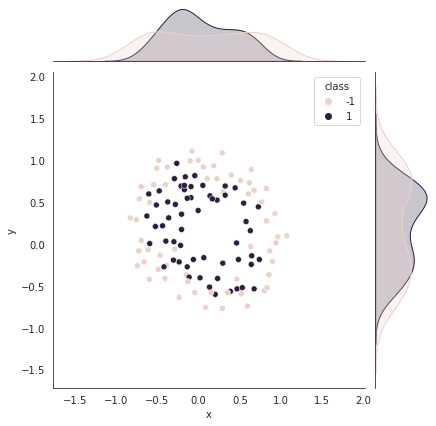

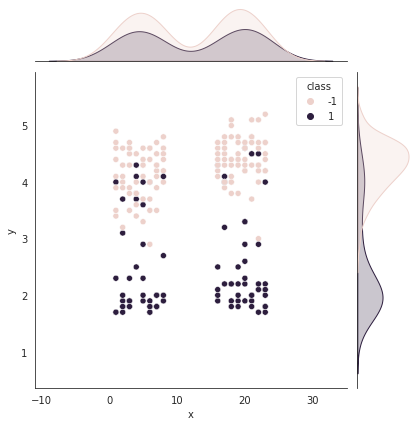

In [55]:
dfs = list(map(lambda name: pd.read_csv(name + '.csv').sample(frac=1), ['chips', 'geyser']))
for df in dfs:
    df.replace({'P': 1, 'N': -1}, inplace=True)
    with sns.axes_style('white'):
        sns.jointplot("x", "y", data=df, kind='scatter', hue='class')

In [37]:
models = defaultdict(list)

def compute_best_clf(df, kernel_type=linear):
    x_raw = df[['x', 'y']].to_numpy()
    y_raw = df['class'].to_numpy()
    
    param_grid = {'kernel': kernel_type,
                  'C': [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}
    
    clf = GridSearchCV(SVM(), param_grid, cv=5, iid='deprecated', scoring='accuracy')    
    clf.fit(x_raw, y_raw)
    print(clf.best_score_)

    res = clf.best_estimator_
    res.fit(x_raw, y_raw)

    print(res.kernel.__name__, res.C)
    return res

In [56]:
def plot(df, clf):
    x_min = df['x'].min()
    x_max = df['x'].max()
    y_min = df['y'].min()
    y_max = df['y'].max()
    xx = np.ogrid[x_min:x_max:20j]
    yy = np.ogrid[y_min:y_max:20j]
    space = [(xi, yi) for xi in xx for yi in yy]
    x, y = zip(*space)

    background = pd.DataFrame({'x': x, 'y': y, 'class': clf.predict(space)})    
    # zz = background['class'].to_numpy().reshape(len(xx), len(yy))
    # plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    # plt.scatter(df['x'], df['y'], c=df['class'], cmap=plt.cm.coolwarm)
    # plt.show()

    sns.jointplot(x='x', y='y', data=background, hue='class')

Chips
0.4235507246376812
linear 5.0
0.8311594202898551
polynomial_2 100.0
0.8221014492753623
guassian_1 5.0
Geyser
0.9008080808080807
linear 0.5
0.8918181818181818
polynomial_2 0.1
0.8962626262626262
guassian_1 0.5


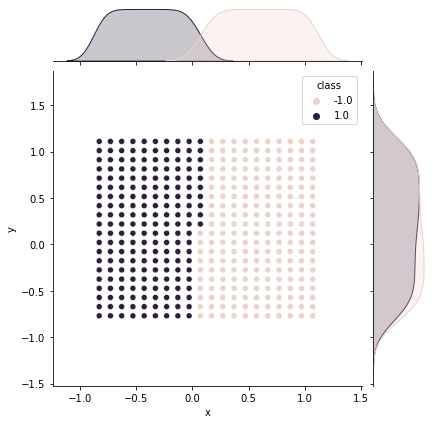

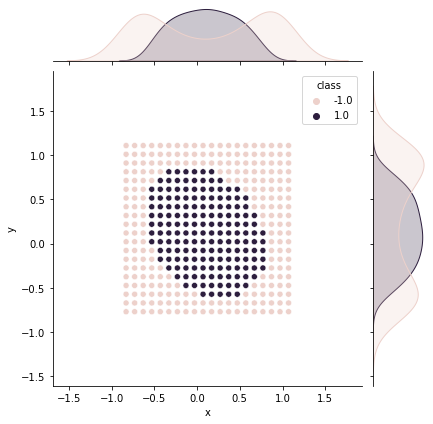

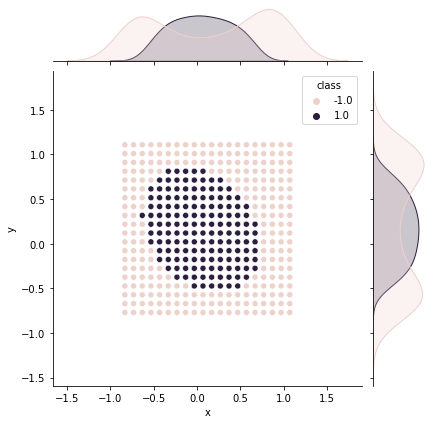

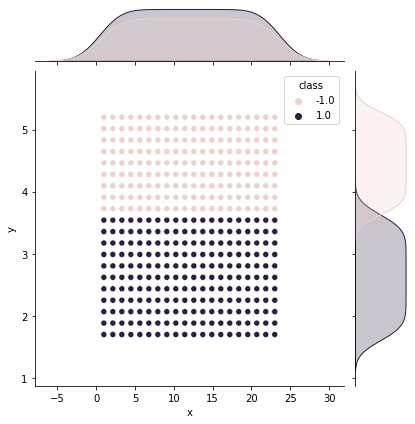

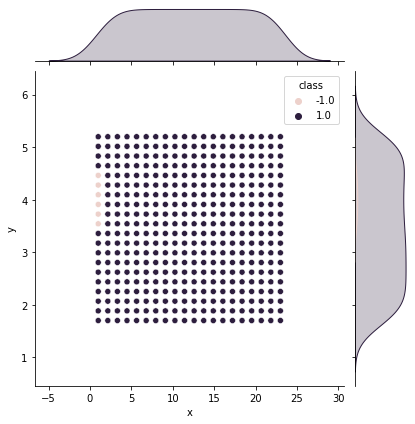

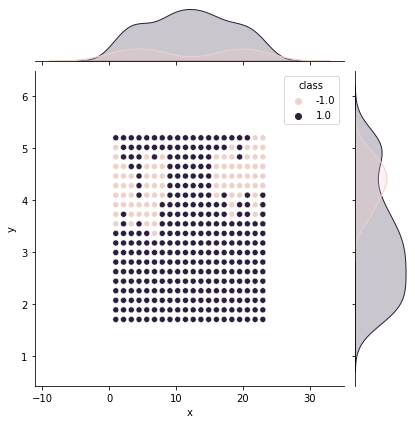

In [57]:
for df, name in zip(dfs, ['Chips', 'Geyser']):
    print(name)
    for kernel_type in [linear, polynomial, guassian]:
        clf = compute_best_clf(df, kernel_type=kernel_type)
        plot(df, clf)

In [65]:
%%time

clfs = [[], []]
for df, df_clfs in zip(dfs, clfs):
    for kernel_type in [linear, polynomial, guassian]:
        df_clfs.append(compute_best_clf(df, kernel_type=kernel_type))

0.4235507246376812
linear 5.0


TypeError: append() takes no keyword arguments

In [ ]:
for df, df_clfs in zip(dfs, clfs):
    for clf in df_clfs:
        plot(df, clf)